In [1]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import matplotlib.pyplot as plt

import torch.nn as nn

from tqdm import tqdm
import copy

from Data import load_df, ChannelJitter, RandomNoise
from Network import Unet, ssim_loss, ConvolutionBlock, ASPP

path = "datasets/" + "with_labels/"
device = "cuda"

IM = torch.tensor([ 0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5,
                    0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5,
                    0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5, 0.0]).to(device)

IS = torch.tensor([0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5,
                   0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5,
                   0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5, 1.0]).to(device)

df = load_df(path)
df_z = df[df["mean"] < 0.2].sample(frac=0.1)
df = pd.concat([df[df["mean"] >= 0.2], df_z])

df.head()

,lat,lon,year,month,day,mean,filename
5,-3.95,-54.78,2021,5,1,0.94,Labeled_-3.95_-54.78_2021_05_01_0.94.npy
7,-4.03,-54.72,2020,8,1,0.46,Labeled_-4.03_-54.72_2020_08_01_0.46.npy
9,-3.47,-54.78,2018,6,1,0.58,Labeled_-3.47_-54.78_2018_06_01_0.58.npy
11,-4.19,-54.98,2020,8,1,0.74,Labeled_-4.19_-54.98_2020_08_01_0.74.npy
13,-3.77,-54.76,2019,8,1,0.32,Labeled_-3.77_-54.76_2019_08_01_0.32.npy


In [2]:
class SatelliteDataset(Dataset):
    def __init__(self, path, positions, df):
        self.img_dir = path

        self.positions = positions.copy()
        self.images = df.copy()

    def __len__(self):
        return self.positions.shape[0]

    def __getitem__(self, idx):
        
        position = self.positions.iloc[idx]
        series = self.images[(self.images["lat"] == position["lat"]) & (self.images["lon"] == position["lon"])]

        filename = series.sample(1)["filename"].values[0]

        img = np.load(self.img_dir + filename)
        return torch.tensor(img).permute(2, 0, 1)

# Results depend on validation set, so we fix the seed
np.random.seed(0)
torch.manual_seed(0)

positions = df[["lat", "lon"]].drop_duplicates()

train_positions = positions.sample(frac=0.8)
val_positions   = positions.drop(train_positions.index)

train_ds = SatelliteDataset(path, train_positions, df)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

val_ds = SatelliteDataset(path, val_positions, df)
val_dl = DataLoader(val_ds, batch_size=len(val_ds) * 8, shuffle=True, num_workers=16)

test_dl = DataLoader(train_ds, batch_size=len(val_ds), shuffle=True, num_workers=16)

len(train_ds), len(val_ds)

(1026, 257)

In [3]:
train_transform = v2.Compose([
    v2.RandomApply([v2.RandomRotation(360, interpolation=v2.InterpolationMode.BILINEAR)], p=0.5),
    v2.RandomHorizontalFlip(p=0.5),

    v2.RandomCrop((64, 64)),
    v2.Normalize(IM, IS),
    
    v2.RandomApply([v2.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.2),
    v2.RandomApply([ChannelJitter(0.2, 0.2)], p=0.2),
    v2.RandomApply([RandomNoise(0.2)], p=0.2),
])

val_transform = v2.Compose([
    v2.CenterCrop((64, 64)),
    v2.Normalize(IM, IS),
])

In [4]:
#https://www.mdpi.com/2079-9292/11/1/130
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc = nn.Sequential(
            ConvolutionBlock(8, 8, kernel_size=3),
            ASPP(8, 8),
        )

        self.unet = Unet(8 * 3, 16, attention=True)

        self.conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            #nn.Sigmoid() # Sigmoid is included in the loss
        )

    def forward(self, x):

        # x shape is (batch, 24, 64, 64)

        # Divide the second channel in x0, x1 and x2
        x0, x1, x2 = torch.split(x, 8, dim=1)
        x0 = self.enc(x0)
        x1 = self.enc(x1)
        x2 = self.enc(x2)

        # Concatenate the three channels
        x = torch.cat([x0, x1, x2], dim=1)

        x = self.unet(x)
        x = self.conv(x)

        if not self.training:
            x *= 1000000

        return x

model = Network().to(device)

In [5]:
@torch.no_grad()
def plot_images():
    data = next(iter(val_dl)).to(device)
    data = val_transform(data)

    im = data[:, :-1]
    lb = data[:, [-1]]
    
    out = torch.sigmoid(model(im))

    im0 = (im[0][3:6] * IS[3:6, None, None]) + IM[3:6, None, None]
    im0 = im0.permute(1, 2, 0).clip(0,1).cpu().numpy()

    im1 = (im[0][11:14] * IS[11:14, None, None]) + IM[11:14, None, None]
    im1 = im1.permute(1, 2, 0).clip(0,1).cpu().numpy()

    im2 = (im[0][19:22] * IS[19:22, None, None]) + IM[19:22, None, None]
    im2 = im2.permute(1, 2, 0).clip(0,1).cpu().numpy()

    label = lb[0][0].cpu().numpy()
    output = out[0][0].detach().cpu().numpy()

    fig, axes = plt.subplots(1, 5, figsize=(15, 10))
    axes[0].imshow(im0)
    axes[1].imshow(im1)
    axes[2].imshow(im2)
    axes[3].imshow(label, vmin=0, vmax=1)
    axes[4].imshow(output, vmin=0, vmax=1)
    plt.show()

In [6]:
@torch.no_grad()
def f1_score(dl):
    data = next(iter(dl)).to(device)
    data = val_transform(data)

    im = data[:, :-1]
    lb = data[:, [-1]]

    output = torch.sigmoid(model(im))

    tp = torch.sum(output * lb)
    fp = torch.sum(output * (1-lb))
    fn = torch.sum((1-output) * lb)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * (precision * recall) / (precision + recall)
    
    union = tp + fp + fn
    iou = tp / union # recall / (recall + 1) ?

    return float(f1), float(iou)

In [7]:
model.train()

bce_loss = nn.BCEWithLogitsLoss()
loss_fn = lambda output, target: bce_loss(output, target) + 2 * ssim_loss(torch.sigmoid(output), target)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

epochs = 300
patience = 100

best_f1 = 0
best_model = copy.deepcopy(model.state_dict())
pat_count = 0

val_losses = []
train_losses = []

for i in range(epochs):
    model.train()

    # Train
    pbar = tqdm(train_dl, miniters=5)
    for data in pbar:
        optimizer.zero_grad()
        
        data = data.to(device)
        data = torch.stack([train_transform(x) for x in data])
        im = data[:, :-1]
        lb = data[:, [-1]]

        out = model(im)
        loss = loss_fn(out, lb).mean()
        pbar.set_description(f"Epoch {i}. Loss: {loss:.4f}", refresh=False)
        
        loss.backward()
        optimizer.step()
    
    # Eval
    with torch.no_grad():
        model.eval()

        f1, iou = f1_score(val_dl)
        val_losses.append((f1, iou))

        if best_f1 < f1:
            best_f1 = f1
            best_model = copy.deepcopy(model.state_dict())
            pat_count = 0
            print(f'{f1:.5f} *')
        else:
            print(f'{f1:.5f}')

        f1, iou = f1_score(test_dl)
        train_losses.append((f1, iou))

        pat_count = pat_count + 1
        if pat_count == patience:
            print("Patience ended.")
            break

model.load_state_dict(best_model)

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 0. Loss: 1.3472: 100%|██████████| 65/65 [00:09<00:00,  6.95it/s]


0.63231 *


Epoch 1. Loss: 1.4759: 100%|██████████| 65/65 [00:04<00:00, 14.08it/s]


0.71202 *


Epoch 2. Loss: 0.9843: 100%|██████████| 65/65 [00:03<00:00, 17.74it/s]


0.72117 *


Epoch 3. Loss: 1.0702: 100%|██████████| 65/65 [00:03<00:00, 18.06it/s]


0.72183 *


Epoch 4. Loss: 1.3320: 100%|██████████| 65/65 [00:03<00:00, 19.62it/s]


0.73830 *


Epoch 5. Loss: 1.1263: 100%|██████████| 65/65 [00:03<00:00, 19.30it/s]


0.73632


Epoch 6. Loss: 1.7955: 100%|██████████| 65/65 [00:03<00:00, 19.11it/s]


0.71945


Traceback (most recent call last):
  File "/home/emap/danilo/anaconda3/envs/torch/lib/python3.12/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/emap/danilo/anaconda3/envs/torch/lib/python3.12/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/emap/danilo/anaconda3/envs/torch/lib/python3.12/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/emap/danilo/anaconda3/envs/torch/lib/python3.12/shutil.py", line 784, in rmtree
    onexc(os.rmdir, path, err)
  File "/home/emap/danilo/anaconda3/envs/torch/lib/python3.12/shutil.py", line 782, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ecy3zn60'
Epoch 7. Loss: 0.8631: 100%|██████████| 65/65 [00:03<00:00, 19.07it/s]


0.76287 *


Epoch 8. Loss: 1.0867: 100%|██████████| 65/65 [00:03<00:00, 19.97it/s]


0.79266 *


Epoch 9. Loss: 1.7854: 100%|██████████| 65/65 [00:03<00:00, 20.07it/s]


0.77280


Epoch 10. Loss: 1.1550: 100%|██████████| 65/65 [00:03<00:00, 20.01it/s]


0.77816


Epoch 11. Loss: 1.2861: 100%|██████████| 65/65 [00:03<00:00, 19.81it/s]


0.80059 *


Epoch 12. Loss: 1.5681: 100%|██████████| 65/65 [00:03<00:00, 19.81it/s]


0.77940


Epoch 13. Loss: 1.0390: 100%|██████████| 65/65 [00:03<00:00, 19.92it/s]


0.80734 *


Epoch 14. Loss: 1.3082: 100%|██████████| 65/65 [00:03<00:00, 19.87it/s]


0.81103 *


Epoch 15. Loss: 1.2021: 100%|██████████| 65/65 [00:03<00:00, 19.97it/s]


0.79865


Epoch 16. Loss: 1.2399: 100%|██████████| 65/65 [00:03<00:00, 19.75it/s]


0.81118 *


Epoch 17. Loss: 1.7696: 100%|██████████| 65/65 [00:03<00:00, 19.71it/s]


0.79767


Epoch 18. Loss: 1.6840: 100%|██████████| 65/65 [00:03<00:00, 19.68it/s]


0.80906


Epoch 19. Loss: 0.9923: 100%|██████████| 65/65 [00:03<00:00, 18.53it/s]


0.81659 *


Epoch 20. Loss: 1.0240: 100%|██████████| 65/65 [00:03<00:00, 19.80it/s]


0.82197 *


Epoch 21. Loss: 1.3774: 100%|██████████| 65/65 [00:03<00:00, 19.78it/s]


0.80486


Epoch 22. Loss: 1.5145: 100%|██████████| 65/65 [00:03<00:00, 19.96it/s]


0.80996


Epoch 23. Loss: 0.9847: 100%|██████████| 65/65 [00:03<00:00, 19.95it/s]


0.81478


Epoch 24. Loss: 1.0523: 100%|██████████| 65/65 [00:03<00:00, 19.82it/s]


0.82402 *


Epoch 25. Loss: 0.9222: 100%|██████████| 65/65 [00:03<00:00, 19.99it/s]


0.81523


Epoch 26. Loss: 0.9892: 100%|██████████| 65/65 [00:03<00:00, 19.67it/s]


0.82314


Epoch 27. Loss: 0.8075: 100%|██████████| 65/65 [00:03<00:00, 20.14it/s]


0.82780 *


Epoch 28. Loss: 1.4707: 100%|██████████| 65/65 [00:03<00:00, 19.97it/s]


0.81907


Epoch 29. Loss: 0.8089: 100%|██████████| 65/65 [00:03<00:00, 19.98it/s]


0.83014 *


Epoch 30. Loss: 0.9984: 100%|██████████| 65/65 [00:03<00:00, 19.91it/s]


0.81349


Epoch 31. Loss: 0.8915: 100%|██████████| 65/65 [00:03<00:00, 19.90it/s]


0.83444 *


Epoch 32. Loss: 1.1913: 100%|██████████| 65/65 [00:03<00:00, 19.54it/s]


0.82496


Epoch 33. Loss: 1.7570: 100%|██████████| 65/65 [00:03<00:00, 19.91it/s]


0.83248


Epoch 34. Loss: 1.6976: 100%|██████████| 65/65 [00:03<00:00, 19.61it/s]


0.83508 *


Epoch 35. Loss: 1.2094: 100%|██████████| 65/65 [00:03<00:00, 19.24it/s]


0.81939


Epoch 36. Loss: 1.6848: 100%|██████████| 65/65 [00:03<00:00, 19.69it/s]


0.82615


Epoch 37. Loss: 1.2030: 100%|██████████| 65/65 [00:03<00:00, 19.95it/s]


0.83425


Epoch 38. Loss: 0.9681: 100%|██████████| 65/65 [00:03<00:00, 19.90it/s]


0.84066 *


Epoch 39. Loss: 1.7503: 100%|██████████| 65/65 [00:03<00:00, 19.83it/s]


0.82628


Epoch 40. Loss: 1.7413: 100%|██████████| 65/65 [00:03<00:00, 20.00it/s]


0.83013


Epoch 41. Loss: 1.0974: 100%|██████████| 65/65 [00:03<00:00, 20.04it/s]


0.84489 *


Epoch 42. Loss: 0.9971: 100%|██████████| 65/65 [00:03<00:00, 19.98it/s]


0.84009


Epoch 43. Loss: 1.1367: 100%|██████████| 65/65 [00:03<00:00, 19.71it/s]


0.84278


Epoch 44. Loss: 0.9543: 100%|██████████| 65/65 [00:03<00:00, 19.85it/s]


0.83250


Epoch 45. Loss: 1.2625: 100%|██████████| 65/65 [00:03<00:00, 19.75it/s]


0.84102


Epoch 46. Loss: 0.7584: 100%|██████████| 65/65 [00:03<00:00, 19.54it/s]


0.83787


Epoch 47. Loss: 1.2472: 100%|██████████| 65/65 [00:03<00:00, 20.06it/s]


0.84516 *


Epoch 48. Loss: 1.1028: 100%|██████████| 65/65 [00:03<00:00, 20.01it/s]


0.83499


Epoch 49. Loss: 1.6583: 100%|██████████| 65/65 [00:03<00:00, 19.69it/s]


0.83579


Epoch 50. Loss: 1.7343: 100%|██████████| 65/65 [00:03<00:00, 19.92it/s]


0.83723


Epoch 51. Loss: 1.2959: 100%|██████████| 65/65 [00:03<00:00, 19.90it/s]


0.82973


Epoch 52. Loss: 0.9060: 100%|██████████| 65/65 [00:03<00:00, 19.46it/s]


0.84261


Epoch 53. Loss: 1.3083: 100%|██████████| 65/65 [00:03<00:00, 20.07it/s]


0.84488


Epoch 54. Loss: 1.7075: 100%|██████████| 65/65 [00:03<00:00, 19.46it/s]


0.83970


Epoch 55. Loss: 1.0791: 100%|██████████| 65/65 [00:03<00:00, 19.52it/s]


0.84308


Epoch 56. Loss: 1.0616: 100%|██████████| 65/65 [00:03<00:00, 19.40it/s]


0.84867 *


Epoch 57. Loss: 0.8877: 100%|██████████| 65/65 [00:03<00:00, 19.35it/s]


0.85131 *


Epoch 58. Loss: 0.6302: 100%|██████████| 65/65 [00:03<00:00, 19.46it/s]


0.85156 *


Epoch 59. Loss: 0.9582: 100%|██████████| 65/65 [00:03<00:00, 18.89it/s]


0.85405 *


Epoch 60. Loss: 1.0526: 100%|██████████| 65/65 [00:03<00:00, 19.96it/s]


0.85347


Epoch 61. Loss: 0.9274: 100%|██████████| 65/65 [00:03<00:00, 20.00it/s]


0.84442


Epoch 62. Loss: 1.7258: 100%|██████████| 65/65 [00:03<00:00, 19.93it/s]


0.84929


Epoch 63. Loss: 1.0547: 100%|██████████| 65/65 [00:03<00:00, 19.53it/s]


0.83810


Epoch 64. Loss: 0.7602: 100%|██████████| 65/65 [00:03<00:00, 19.49it/s]


0.85160


Epoch 65. Loss: 1.3035: 100%|██████████| 65/65 [00:03<00:00, 19.69it/s]


0.85234


Epoch 66. Loss: 1.4808: 100%|██████████| 65/65 [00:03<00:00, 19.89it/s]


0.84766


Epoch 67. Loss: 0.6046: 100%|██████████| 65/65 [00:03<00:00, 19.99it/s]


0.84817


Epoch 68. Loss: 1.1989: 100%|██████████| 65/65 [00:03<00:00, 19.64it/s]


0.83750


Epoch 69. Loss: 1.7119: 100%|██████████| 65/65 [00:03<00:00, 20.00it/s]


0.85002


Epoch 70. Loss: 0.6427: 100%|██████████| 65/65 [00:03<00:00, 19.82it/s]


0.85486 *


Epoch 71. Loss: 0.9318: 100%|██████████| 65/65 [00:03<00:00, 19.98it/s]


0.84888


Epoch 72. Loss: 0.6857: 100%|██████████| 65/65 [00:03<00:00, 19.93it/s]


0.84451


Epoch 73. Loss: 1.7221: 100%|██████████| 65/65 [00:03<00:00, 19.49it/s]


0.84433


Epoch 74. Loss: 1.0788: 100%|██████████| 65/65 [00:03<00:00, 20.10it/s]


0.85535 *


Epoch 75. Loss: 1.7086: 100%|██████████| 65/65 [00:03<00:00, 19.76it/s]


0.84037


Epoch 76. Loss: 1.1299: 100%|██████████| 65/65 [00:03<00:00, 19.94it/s]


0.85552 *


Epoch 77. Loss: 1.0244: 100%|██████████| 65/65 [00:03<00:00, 19.93it/s]


0.84945


Epoch 78. Loss: 0.9714: 100%|██████████| 65/65 [00:03<00:00, 19.87it/s]


0.85089


Epoch 79. Loss: 0.8773: 100%|██████████| 65/65 [00:03<00:00, 19.87it/s]


0.83664


Epoch 80. Loss: 1.7112: 100%|██████████| 65/65 [00:03<00:00, 19.95it/s]


0.83776


Epoch 81. Loss: 0.9874: 100%|██████████| 65/65 [00:03<00:00, 19.89it/s]


0.85929 *


Epoch 82. Loss: 0.9539: 100%|██████████| 65/65 [00:03<00:00, 19.96it/s]


0.85261


Epoch 83. Loss: 1.7075: 100%|██████████| 65/65 [00:03<00:00, 19.90it/s]


0.85687


Epoch 84. Loss: 0.9312: 100%|██████████| 65/65 [00:03<00:00, 19.81it/s]


0.85824


Epoch 85. Loss: 0.7331: 100%|██████████| 65/65 [00:03<00:00, 19.99it/s]


0.84656


Epoch 86. Loss: 1.7054: 100%|██████████| 65/65 [00:03<00:00, 19.95it/s]


0.85634


Epoch 87. Loss: 1.0310: 100%|██████████| 65/65 [00:03<00:00, 19.14it/s]


0.84270


Epoch 88. Loss: 0.5540: 100%|██████████| 65/65 [00:03<00:00, 19.75it/s]


0.85053


Epoch 89. Loss: 1.1131: 100%|██████████| 65/65 [00:03<00:00, 19.88it/s]


0.85384


Epoch 90. Loss: 1.2460: 100%|██████████| 65/65 [00:03<00:00, 19.25it/s]


0.85354


Epoch 91. Loss: 1.3596: 100%|██████████| 65/65 [00:03<00:00, 19.84it/s]


0.84371


Epoch 92. Loss: 1.0167: 100%|██████████| 65/65 [00:03<00:00, 19.97it/s]


0.86124 *


Epoch 93. Loss: 1.3883: 100%|██████████| 65/65 [00:03<00:00, 19.96it/s]


0.84757


Epoch 94. Loss: 1.1981: 100%|██████████| 65/65 [00:03<00:00, 19.74it/s]


0.84982


Epoch 95. Loss: 1.7058: 100%|██████████| 65/65 [00:03<00:00, 19.76it/s]


0.86192 *


Epoch 96. Loss: 0.5165: 100%|██████████| 65/65 [00:03<00:00, 19.91it/s]


0.85620


Epoch 97. Loss: 0.8266: 100%|██████████| 65/65 [00:03<00:00, 19.88it/s]


0.84226


Epoch 98. Loss: 1.3075: 100%|██████████| 65/65 [00:03<00:00, 19.98it/s]


0.85976


Epoch 99. Loss: 1.1166: 100%|██████████| 65/65 [00:03<00:00, 19.89it/s]


0.85197


Epoch 100. Loss: 1.7052: 100%|██████████| 65/65 [00:03<00:00, 19.92it/s]


0.85484


Epoch 101. Loss: 1.6254: 100%|██████████| 65/65 [00:03<00:00, 19.30it/s]


0.85666


Epoch 102. Loss: 1.6600: 100%|██████████| 65/65 [00:03<00:00, 19.79it/s]


0.85176


Epoch 103. Loss: 1.1715: 100%|██████████| 65/65 [00:03<00:00, 19.77it/s]


0.85624


Epoch 104. Loss: 1.0089: 100%|██████████| 65/65 [00:03<00:00, 19.95it/s]


0.85745


Epoch 105. Loss: 1.1642: 100%|██████████| 65/65 [00:03<00:00, 19.87it/s]


0.85576


Epoch 106. Loss: 1.7016: 100%|██████████| 65/65 [00:03<00:00, 19.92it/s]


0.86000


Epoch 107. Loss: 1.4687: 100%|██████████| 65/65 [00:03<00:00, 19.92it/s]


0.85297


Epoch 108. Loss: 1.0137: 100%|██████████| 65/65 [00:03<00:00, 19.69it/s]


0.85033


Epoch 109. Loss: 0.8946: 100%|██████████| 65/65 [00:03<00:00, 19.84it/s]


0.85619


Epoch 110. Loss: 0.9370: 100%|██████████| 65/65 [00:03<00:00, 19.92it/s]


0.84938


Epoch 111. Loss: 1.0549: 100%|██████████| 65/65 [00:03<00:00, 19.85it/s]


0.84242


Epoch 112. Loss: 0.5380: 100%|██████████| 65/65 [00:03<00:00, 19.92it/s]


0.84921


Epoch 113. Loss: 0.6459: 100%|██████████| 65/65 [00:03<00:00, 19.69it/s]


0.84788


Epoch 114. Loss: 0.4590: 100%|██████████| 65/65 [00:03<00:00, 19.66it/s]


0.85467


Epoch 115. Loss: 1.1152: 100%|██████████| 65/65 [00:03<00:00, 20.10it/s]


0.86232 *


Epoch 116. Loss: 1.6841: 100%|██████████| 65/65 [00:03<00:00, 19.43it/s]


0.85118


Epoch 117. Loss: 0.4665: 100%|██████████| 65/65 [00:03<00:00, 19.54it/s]


0.85884


Epoch 118. Loss: 0.7212: 100%|██████████| 65/65 [00:03<00:00, 19.87it/s]


0.85492


Epoch 119. Loss: 0.9842: 100%|██████████| 65/65 [00:03<00:00, 19.61it/s]


0.85551


Epoch 120. Loss: 1.1837: 100%|██████████| 65/65 [00:03<00:00, 19.66it/s]


0.85822


Epoch 121. Loss: 0.6725: 100%|██████████| 65/65 [00:03<00:00, 19.84it/s]


0.85276


Epoch 122. Loss: 0.6330: 100%|██████████| 65/65 [00:03<00:00, 19.77it/s]


0.85999


Epoch 123. Loss: 0.8830: 100%|██████████| 65/65 [00:03<00:00, 19.69it/s]


0.85029


Epoch 124. Loss: 1.0258: 100%|██████████| 65/65 [00:03<00:00, 19.90it/s]


0.84812


Epoch 125. Loss: 0.8648: 100%|██████████| 65/65 [00:03<00:00, 19.86it/s]


0.85611


Epoch 126. Loss: 0.8915: 100%|██████████| 65/65 [00:03<00:00, 19.86it/s]


0.85183


Epoch 127. Loss: 0.7502: 100%|██████████| 65/65 [00:03<00:00, 19.97it/s]


0.86329 *


Epoch 128. Loss: 0.7036: 100%|██████████| 65/65 [00:03<00:00, 20.14it/s]


0.84718


Epoch 129. Loss: 0.6589: 100%|██████████| 65/65 [00:03<00:00, 20.11it/s]


0.85366


Epoch 130. Loss: 0.5381: 100%|██████████| 65/65 [00:03<00:00, 20.01it/s]


0.85712


Epoch 131. Loss: 1.6946: 100%|██████████| 65/65 [00:03<00:00, 19.31it/s]


0.85098


Epoch 132. Loss: 0.6388: 100%|██████████| 65/65 [00:03<00:00, 19.73it/s]


0.85815


Epoch 133. Loss: 1.6286: 100%|██████████| 65/65 [00:03<00:00, 19.66it/s]


0.85781


Epoch 134. Loss: 0.4385: 100%|██████████| 65/65 [00:03<00:00, 19.97it/s]


0.85537


Epoch 135. Loss: 1.6860: 100%|██████████| 65/65 [00:03<00:00, 20.05it/s]


0.85688


Epoch 136. Loss: 1.1945: 100%|██████████| 65/65 [00:03<00:00, 20.01it/s]


0.86312


Epoch 137. Loss: 0.9665: 100%|██████████| 65/65 [00:03<00:00, 19.85it/s]


0.85789


Epoch 138. Loss: 0.9675: 100%|██████████| 65/65 [00:03<00:00, 20.01it/s]


0.85239


Epoch 139. Loss: 0.8456: 100%|██████████| 65/65 [00:03<00:00, 19.59it/s]


0.85751


Epoch 140. Loss: 0.9339: 100%|██████████| 65/65 [00:03<00:00, 19.96it/s]


0.85786


Epoch 141. Loss: 0.8941: 100%|██████████| 65/65 [00:03<00:00, 20.00it/s]


0.85997


Epoch 142. Loss: 0.9600: 100%|██████████| 65/65 [00:03<00:00, 20.02it/s]


0.85480


Epoch 143. Loss: 0.9421: 100%|██████████| 65/65 [00:03<00:00, 19.93it/s]


0.84912


Epoch 144. Loss: 0.8109: 100%|██████████| 65/65 [00:03<00:00, 19.51it/s]


0.85552


Epoch 145. Loss: 1.4283: 100%|██████████| 65/65 [00:03<00:00, 19.43it/s]


0.85124


Epoch 146. Loss: 1.6511: 100%|██████████| 65/65 [00:03<00:00, 19.92it/s]


0.86278


Epoch 147. Loss: 0.8455: 100%|██████████| 65/65 [00:03<00:00, 19.90it/s]


0.85637


Epoch 148. Loss: 0.7326: 100%|██████████| 65/65 [00:03<00:00, 19.96it/s]


0.85811


Epoch 149. Loss: 0.4217: 100%|██████████| 65/65 [00:03<00:00, 19.94it/s]


0.85802


Epoch 150. Loss: 1.5789: 100%|██████████| 65/65 [00:03<00:00, 19.84it/s]


0.85835


Epoch 151. Loss: 0.9294: 100%|██████████| 65/65 [00:03<00:00, 20.03it/s]


0.85200


Epoch 152. Loss: 0.6950: 100%|██████████| 65/65 [00:03<00:00, 20.02it/s]


0.85469


Epoch 153. Loss: 0.7285: 100%|██████████| 65/65 [00:03<00:00, 20.10it/s]


0.86218


Epoch 154. Loss: 0.4869: 100%|██████████| 65/65 [00:03<00:00, 19.88it/s]


0.86067


Epoch 155. Loss: 1.6603: 100%|██████████| 65/65 [00:03<00:00, 19.75it/s]


0.86423 *


Epoch 156. Loss: 0.9303: 100%|██████████| 65/65 [00:03<00:00, 19.84it/s]


0.85617


Epoch 157. Loss: 0.5843: 100%|██████████| 65/65 [00:03<00:00, 19.93it/s]


0.85888


Epoch 158. Loss: 1.0726: 100%|██████████| 65/65 [00:03<00:00, 19.66it/s]


0.85326


Epoch 159. Loss: 1.5409: 100%|██████████| 65/65 [00:03<00:00, 19.92it/s]


0.86132


Epoch 160. Loss: 0.5014: 100%|██████████| 65/65 [00:03<00:00, 19.56it/s]


0.85723


Epoch 161. Loss: 0.8733: 100%|██████████| 65/65 [00:03<00:00, 19.95it/s]


0.86173


Epoch 162. Loss: 0.6969: 100%|██████████| 65/65 [00:03<00:00, 19.96it/s]


0.84652


Epoch 163. Loss: 1.6518: 100%|██████████| 65/65 [00:03<00:00, 19.94it/s]


0.86076


Epoch 164. Loss: 0.5810: 100%|██████████| 65/65 [00:03<00:00, 19.87it/s]


0.85714


Epoch 165. Loss: 0.5772: 100%|██████████| 65/65 [00:03<00:00, 19.20it/s]


0.84886


Epoch 166. Loss: 0.7356: 100%|██████████| 65/65 [00:03<00:00, 19.98it/s]


0.85418


Epoch 167. Loss: 1.5238: 100%|██████████| 65/65 [00:03<00:00, 19.92it/s]


0.85684


Epoch 168. Loss: 0.9825: 100%|██████████| 65/65 [00:03<00:00, 19.94it/s]


0.86510 *


Epoch 169. Loss: 0.5780: 100%|██████████| 65/65 [00:03<00:00, 20.16it/s]


0.86639 *


Epoch 170. Loss: 0.8677: 100%|██████████| 65/65 [00:03<00:00, 20.07it/s]


0.86242


Epoch 171. Loss: 0.8879: 100%|██████████| 65/65 [00:03<00:00, 19.67it/s]


0.86155


Epoch 172. Loss: 0.8910: 100%|██████████| 65/65 [00:03<00:00, 19.79it/s]


0.86005


Epoch 173. Loss: 0.7404: 100%|██████████| 65/65 [00:03<00:00, 19.89it/s]


0.85600


Epoch 174. Loss: 0.8150: 100%|██████████| 65/65 [00:03<00:00, 19.36it/s]


0.86180


Epoch 175. Loss: 1.6653: 100%|██████████| 65/65 [00:03<00:00, 19.86it/s]


0.85833


Epoch 176. Loss: 1.5013: 100%|██████████| 65/65 [00:03<00:00, 20.08it/s]


0.86061


Epoch 177. Loss: 0.9703: 100%|██████████| 65/65 [00:03<00:00, 19.50it/s]


0.86666 *


Epoch 178. Loss: 1.6988: 100%|██████████| 65/65 [00:03<00:00, 19.97it/s]


0.83966


Epoch 179. Loss: 0.7182: 100%|██████████| 65/65 [00:03<00:00, 20.01it/s]


0.84718


Epoch 180. Loss: 0.5271: 100%|██████████| 65/65 [00:03<00:00, 19.66it/s]


0.86464


Epoch 181. Loss: 0.4757: 100%|██████████| 65/65 [00:03<00:00, 19.95it/s]


0.86063


Epoch 182. Loss: 1.4634: 100%|██████████| 65/65 [00:03<00:00, 19.77it/s]


0.85298


Epoch 183. Loss: 1.6334: 100%|██████████| 65/65 [00:03<00:00, 19.98it/s]


0.86971 *


Epoch 184. Loss: 1.6612: 100%|██████████| 65/65 [00:03<00:00, 19.92it/s]


0.86671


Epoch 185. Loss: 1.0605: 100%|██████████| 65/65 [00:03<00:00, 19.68it/s]


0.86425


Epoch 186. Loss: 0.8730: 100%|██████████| 65/65 [00:03<00:00, 19.84it/s]


0.85661


Epoch 187. Loss: 1.0288: 100%|██████████| 65/65 [00:03<00:00, 19.95it/s]


0.86170


Epoch 188. Loss: 0.8388: 100%|██████████| 65/65 [00:03<00:00, 19.88it/s]


0.85801


Epoch 189. Loss: 0.6752: 100%|██████████| 65/65 [00:03<00:00, 19.42it/s]


0.85739


Epoch 190. Loss: 0.6710: 100%|██████████| 65/65 [00:03<00:00, 20.02it/s]


0.85910


Epoch 191. Loss: 0.7344: 100%|██████████| 65/65 [00:03<00:00, 19.89it/s]


0.85821


Epoch 192. Loss: 0.6450: 100%|██████████| 65/65 [00:03<00:00, 19.94it/s]


0.86478


Epoch 193. Loss: 0.7479: 100%|██████████| 65/65 [00:03<00:00, 19.73it/s]


0.85610


Epoch 194. Loss: 0.8257: 100%|██████████| 65/65 [00:03<00:00, 19.91it/s]


0.85273


Epoch 195. Loss: 0.8463: 100%|██████████| 65/65 [00:03<00:00, 19.87it/s]


0.84894


Epoch 196. Loss: 0.6964: 100%|██████████| 65/65 [00:03<00:00, 19.93it/s]


0.85216


Epoch 197. Loss: 0.6787: 100%|██████████| 65/65 [00:03<00:00, 19.66it/s]


0.86034


Epoch 198. Loss: 0.8040: 100%|██████████| 65/65 [00:03<00:00, 19.89it/s]


0.86563


Epoch 199. Loss: 0.8671: 100%|██████████| 65/65 [00:03<00:00, 19.99it/s]


0.85641


Epoch 200. Loss: 0.8659: 100%|██████████| 65/65 [00:03<00:00, 19.88it/s]


0.86444


Epoch 201. Loss: 1.6130: 100%|██████████| 65/65 [00:03<00:00, 20.00it/s]


0.86876


Epoch 202. Loss: 1.6617: 100%|██████████| 65/65 [00:03<00:00, 19.84it/s]


0.85411


Epoch 203. Loss: 1.3684: 100%|██████████| 65/65 [00:03<00:00, 19.04it/s]


0.86298


Epoch 204. Loss: 0.7968: 100%|██████████| 65/65 [00:03<00:00, 19.58it/s]


0.86197


Epoch 205. Loss: 0.7314: 100%|██████████| 65/65 [00:03<00:00, 19.77it/s]


0.86693


Epoch 206. Loss: 0.7833: 100%|██████████| 65/65 [00:03<00:00, 19.78it/s]


0.86098


Epoch 207. Loss: 0.7215: 100%|██████████| 65/65 [00:03<00:00, 19.87it/s]


0.86319


Epoch 208. Loss: 1.2928: 100%|██████████| 65/65 [00:03<00:00, 20.05it/s]


0.86787


Epoch 209. Loss: 0.6912: 100%|██████████| 65/65 [00:03<00:00, 20.01it/s]


0.86041


Epoch 210. Loss: 1.6565: 100%|██████████| 65/65 [00:03<00:00, 19.91it/s]


0.86229


Epoch 211. Loss: 1.6505: 100%|██████████| 65/65 [00:03<00:00, 19.89it/s]


0.86162


Epoch 212. Loss: 0.5770: 100%|██████████| 65/65 [00:03<00:00, 19.94it/s]


0.85331


Epoch 213. Loss: 1.6089: 100%|██████████| 65/65 [00:03<00:00, 19.93it/s]


0.85172


Epoch 214. Loss: 1.5776: 100%|██████████| 65/65 [00:03<00:00, 20.10it/s]


0.85518


Epoch 215. Loss: 0.9374: 100%|██████████| 65/65 [00:03<00:00, 20.00it/s]


0.85470


Epoch 216. Loss: 0.6122: 100%|██████████| 65/65 [00:03<00:00, 19.95it/s]


0.86003


Epoch 217. Loss: 1.6236: 100%|██████████| 65/65 [00:03<00:00, 19.55it/s]


0.86120


Epoch 218. Loss: 1.4667: 100%|██████████| 65/65 [00:03<00:00, 19.47it/s]


0.86448


Epoch 219. Loss: 0.4508: 100%|██████████| 65/65 [00:03<00:00, 19.91it/s]


0.86091


Epoch 220. Loss: 1.7749: 100%|██████████| 65/65 [00:03<00:00, 19.72it/s]


0.84721


Epoch 221. Loss: 1.5602: 100%|██████████| 65/65 [00:03<00:00, 19.96it/s]


0.86155


Epoch 222. Loss: 0.6224: 100%|██████████| 65/65 [00:03<00:00, 19.91it/s]


0.84321


Epoch 223. Loss: 0.6132: 100%|██████████| 65/65 [00:03<00:00, 19.88it/s]


0.86545


Epoch 224. Loss: 1.6379: 100%|██████████| 65/65 [00:03<00:00, 19.87it/s]


0.86457


Epoch 225. Loss: 1.6280: 100%|██████████| 65/65 [00:03<00:00, 19.94it/s]


0.85813


Epoch 226. Loss: 0.8257: 100%|██████████| 65/65 [00:03<00:00, 20.02it/s]


0.86003


Epoch 227. Loss: 0.8515: 100%|██████████| 65/65 [00:03<00:00, 19.91it/s]


0.85996


Epoch 228. Loss: 1.0617: 100%|██████████| 65/65 [00:03<00:00, 19.65it/s]


0.86060


Epoch 229. Loss: 1.5986: 100%|██████████| 65/65 [00:03<00:00, 19.74it/s]


0.85303


Epoch 230. Loss: 0.7561: 100%|██████████| 65/65 [00:03<00:00, 19.90it/s]


0.85887


Epoch 231. Loss: 0.7331: 100%|██████████| 65/65 [00:03<00:00, 19.98it/s]


0.85752


Epoch 232. Loss: 1.6347: 100%|██████████| 65/65 [00:03<00:00, 19.88it/s]


0.86166


Epoch 233. Loss: 0.3119: 100%|██████████| 65/65 [00:03<00:00, 19.28it/s]


0.86116


Epoch 234. Loss: 1.1055: 100%|██████████| 65/65 [00:03<00:00, 20.13it/s]


0.86405


Epoch 235. Loss: 0.6576: 100%|██████████| 65/65 [00:03<00:00, 19.81it/s]


0.85396


Epoch 236. Loss: 1.6400: 100%|██████████| 65/65 [00:03<00:00, 19.49it/s]


0.85809


Epoch 237. Loss: 0.7165: 100%|██████████| 65/65 [00:03<00:00, 19.98it/s]


0.86012


Epoch 238. Loss: 0.6862: 100%|██████████| 65/65 [00:03<00:00, 19.96it/s]


0.86176


Epoch 239. Loss: 0.8225: 100%|██████████| 65/65 [00:03<00:00, 20.04it/s]


0.85695


Epoch 240. Loss: 0.8360: 100%|██████████| 65/65 [00:03<00:00, 20.08it/s]


0.85262


Epoch 241. Loss: 0.8443: 100%|██████████| 65/65 [00:03<00:00, 19.90it/s]


0.86646


Epoch 242. Loss: 0.7211: 100%|██████████| 65/65 [00:03<00:00, 20.00it/s]


0.85648


Epoch 243. Loss: 0.7120: 100%|██████████| 65/65 [00:03<00:00, 19.76it/s]


0.85471


Epoch 244. Loss: 1.6249: 100%|██████████| 65/65 [00:03<00:00, 19.76it/s]


0.85806


Epoch 245. Loss: 1.4712: 100%|██████████| 65/65 [00:03<00:00, 20.04it/s]


0.86169


Epoch 246. Loss: 1.6302: 100%|██████████| 65/65 [00:03<00:00, 19.77it/s]


0.85512


Epoch 247. Loss: 1.3629: 100%|██████████| 65/65 [00:03<00:00, 19.42it/s]


0.85464


Epoch 248. Loss: 0.8068: 100%|██████████| 65/65 [00:03<00:00, 19.37it/s]


0.86025


Epoch 249. Loss: 0.5054: 100%|██████████| 65/65 [00:03<00:00, 19.86it/s]


0.85772


Epoch 250. Loss: 0.5113: 100%|██████████| 65/65 [00:03<00:00, 19.90it/s]


0.86110


Epoch 251. Loss: 0.6334: 100%|██████████| 65/65 [00:03<00:00, 19.82it/s]


0.85739


Epoch 252. Loss: 0.5151: 100%|██████████| 65/65 [00:03<00:00, 19.43it/s]


0.86471


Epoch 253. Loss: 0.4832: 100%|██████████| 65/65 [00:03<00:00, 19.38it/s]


0.86139


Epoch 254. Loss: 0.6663: 100%|██████████| 65/65 [00:03<00:00, 19.99it/s]


0.85963


Epoch 255. Loss: 1.6742: 100%|██████████| 65/65 [00:03<00:00, 19.91it/s]


0.85256


Epoch 256. Loss: 1.6023: 100%|██████████| 65/65 [00:03<00:00, 19.54it/s]


0.86110


Epoch 257. Loss: 1.1101: 100%|██████████| 65/65 [00:03<00:00, 19.48it/s]


0.86420


Epoch 258. Loss: 0.7565: 100%|██████████| 65/65 [00:03<00:00, 19.68it/s]


0.84261


Epoch 259. Loss: 0.7863: 100%|██████████| 65/65 [00:03<00:00, 20.02it/s]


0.85850


Epoch 260. Loss: 2.2557: 100%|██████████| 65/65 [00:03<00:00, 19.96it/s]


0.86375


Epoch 261. Loss: 1.3910: 100%|██████████| 65/65 [00:03<00:00, 19.84it/s]


0.86080


Epoch 262. Loss: 0.8428: 100%|██████████| 65/65 [00:03<00:00, 19.82it/s]


0.86487


Epoch 263. Loss: 1.2865: 100%|██████████| 65/65 [00:03<00:00, 19.45it/s]


0.85857


Epoch 264. Loss: 0.9209: 100%|██████████| 65/65 [00:03<00:00, 19.51it/s]


0.84205


Epoch 265. Loss: 0.8855: 100%|██████████| 65/65 [00:03<00:00, 20.00it/s]


0.87476 *


Epoch 266. Loss: 1.6396: 100%|██████████| 65/65 [00:03<00:00, 20.06it/s]


0.85780


Epoch 267. Loss: 0.8084: 100%|██████████| 65/65 [00:03<00:00, 20.02it/s]


0.86703


Epoch 268. Loss: 1.6101: 100%|██████████| 65/65 [00:03<00:00, 20.04it/s]


0.86325


Epoch 269. Loss: 1.4498: 100%|██████████| 65/65 [00:03<00:00, 20.14it/s]


0.86238


Epoch 270. Loss: 0.8155: 100%|██████████| 65/65 [00:03<00:00, 19.69it/s]


0.85976


Epoch 271. Loss: 0.7445: 100%|██████████| 65/65 [00:03<00:00, 19.68it/s]


0.86530


Epoch 272. Loss: 1.6112: 100%|██████████| 65/65 [00:03<00:00, 19.72it/s]


0.86121


Epoch 273. Loss: 0.6318: 100%|██████████| 65/65 [00:03<00:00, 19.99it/s]


0.85998


Epoch 274. Loss: 0.3571: 100%|██████████| 65/65 [00:03<00:00, 19.94it/s]


0.86717


Epoch 275. Loss: 0.7368: 100%|██████████| 65/65 [00:03<00:00, 19.70it/s]


0.86620


Epoch 276. Loss: 0.4989: 100%|██████████| 65/65 [00:03<00:00, 19.73it/s]


0.86057


Epoch 277. Loss: 1.0322: 100%|██████████| 65/65 [00:03<00:00, 19.56it/s]


0.84992


Epoch 278. Loss: 0.6643: 100%|██████████| 65/65 [00:03<00:00, 19.56it/s]


0.85797


Epoch 279. Loss: 0.7136: 100%|██████████| 65/65 [00:03<00:00, 19.92it/s]


0.86574


Epoch 280. Loss: 0.7226: 100%|██████████| 65/65 [00:03<00:00, 19.95it/s]


0.86569


Epoch 281. Loss: 1.9284: 100%|██████████| 65/65 [00:03<00:00, 20.11it/s]


0.82920


Epoch 282. Loss: 0.8978: 100%|██████████| 65/65 [00:03<00:00, 20.01it/s]


0.85616


Epoch 283. Loss: 1.6216: 100%|██████████| 65/65 [00:03<00:00, 19.84it/s]


0.85850


Epoch 284. Loss: 0.5129: 100%|██████████| 65/65 [00:03<00:00, 19.85it/s]


0.85663


Traceback (most recent call last):
  File "/home/emap/danilo/anaconda3/envs/torch/lib/python3.12/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/emap/danilo/anaconda3/envs/torch/lib/python3.12/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/emap/danilo/anaconda3/envs/torch/lib/python3.12/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/emap/danilo/anaconda3/envs/torch/lib/python3.12/shutil.py", line 784, in rmtree
    onexc(os.rmdir, path, err)
  File "/home/emap/danilo/anaconda3/envs/torch/lib/python3.12/shutil.py", line 782, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-y4r_x1b1'
Epoch 285. Loss: 0.7331: 100%|██████████| 65/65 [00:03<00:00, 19.96it/s]


0.86382


Epoch 286. Loss: 1.1099: 100%|██████████| 65/65 [00:03<00:00, 19.88it/s]


0.85854


Epoch 287. Loss: 1.0673: 100%|██████████| 65/65 [00:03<00:00, 19.81it/s]


0.86460


Epoch 288. Loss: 1.6389: 100%|██████████| 65/65 [00:03<00:00, 19.82it/s]


0.84986


Epoch 289. Loss: 2.1484: 100%|██████████| 65/65 [00:03<00:00, 19.97it/s]


0.83310


Epoch 290. Loss: 0.9197: 100%|██████████| 65/65 [00:03<00:00, 19.85it/s]


0.86765


Epoch 291. Loss: 0.5989: 100%|██████████| 65/65 [00:03<00:00, 19.80it/s]


0.85415


Epoch 292. Loss: 0.3980: 100%|██████████| 65/65 [00:03<00:00, 20.00it/s]


0.85409


Epoch 293. Loss: 1.6322: 100%|██████████| 65/65 [00:03<00:00, 19.37it/s]


0.86369


Epoch 294. Loss: 1.3640: 100%|██████████| 65/65 [00:03<00:00, 19.95it/s]


0.86320


Epoch 295. Loss: 2.3296: 100%|██████████| 65/65 [00:03<00:00, 19.82it/s]


0.86096


Epoch 296. Loss: 1.6318: 100%|██████████| 65/65 [00:03<00:00, 19.81it/s]


0.86504


Epoch 297. Loss: 0.6798: 100%|██████████| 65/65 [00:03<00:00, 20.00it/s]


0.86050


Epoch 298. Loss: 0.6458: 100%|██████████| 65/65 [00:03<00:00, 20.07it/s]


0.86203


Epoch 299. Loss: 1.1373: 100%|██████████| 65/65 [00:03<00:00, 19.90it/s]


0.85368


<All keys matched successfully>

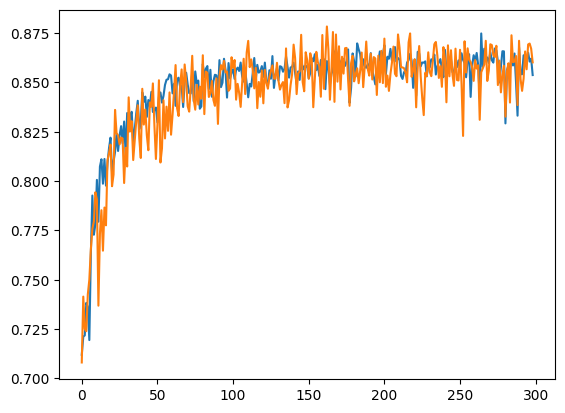

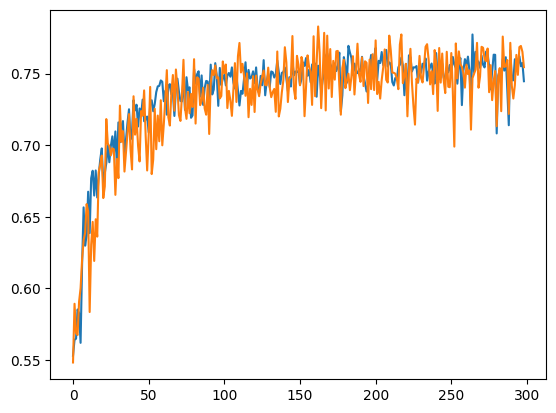

0.8747570514678955


In [8]:
model.eval()

val_f1 = [x[0] for x in val_losses]
val_iou = [x[1] for x in val_losses]

train_f1 = [x[0] for x in train_losses]
train_iou = [x[1] for x in train_losses]

# plot val_losses, train_losses on the same plot
plt.plot(val_f1[1:]) # azul
plt.plot(train_f1[1:]) # laranja
plt.show()

plt.plot(val_iou[1:]) # azul
plt.plot(train_iou[1:]) # laranja
plt.show()

print(max(val_f1))

In [34]:
f1_score(train_dl)

(0.9201673865318298, 0.8521389365196228)

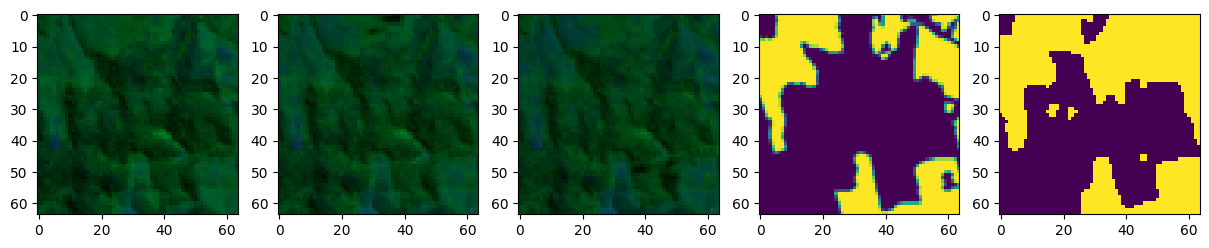

In [43]:
plot_images()